In [1]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [3]:
symbols = list(set(df.symbol))
symbols[:5]

['BBY', 'EOG', 'EQT', 'FBHS', 'EMR']

In [4]:
SYM = 'GOOG'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,312.304948,310.955001,313.580158,312.205308
2010-01-05,312.419511,309.610028,312.748278,310.830459
2010-01-06,311.761979,302.048370,311.761979,302.994813
2010-01-07,303.562685,295.218951,303.861575,295.941242
2010-01-08,294.895159,293.455551,300.499172,299.886470


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.157047,0.161167,0.156390,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.138726


In [6]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
n_features = 4
prev_days = 7
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

[[0.15704696 0.16116746 0.15638998 0.15939908]
 [0.15723843 0.15888449 0.15499506 0.15709185]
 [0.15613951 0.14604929 0.15334121 0.14394234]
 [0.14243617 0.13445699 0.14009362 0.13210528]
 [0.12795029 0.13146379 0.13445546 0.13872603]
 [0.13832355 0.1356323  0.13546617 0.1379653 ]
 [0.13265404 0.13052526 0.13020388 0.12907917]] 0.12624526774310008


In [8]:
def build_model(layers):
    p = 0.25
    model = Sequential()

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [9]:
bestVal = 10000 
saveModel = 0
for loop in range(0, 30):
    print(loop)
    b = model.fit(X_train, y_train, batch_size = 64, epochs = 1, validation_split = 0.1, verbose = 1)
#     print(b.history)
    if(b.history['val_mean_squared_error'][0] < bestVal):
        print("===================")
        bestVal = b.history['val_mean_squared_error'][0]
        model.save('my_model_WBA.h5')

model = load_model('my_model_WBA.h5')

0
Train on 1421 samples, validate on 158 samples
Epoch 1/1
1421/1421 [==============================] - 1s 1ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
1
Train on 1421 samples, validate on 158 samples
Epoch 1/1
1421/1421 [==============================] - 1s 357us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
2
Train on 1421 samples, validate on 158 samples
Epoch 1/1
1421/1421 [==============================] - 1s 392us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
3
Train on 1421 samples, validate on 158 samples
Epoch 1/1
1421/1421 [==============================] - 1s 366us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
4
Train on 1421 samples, validate on 158 samples
Epoch 1/1
1421/1421 [==============================] - 1s 400us/step - loss: 0.0018 - mean_square

In [10]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [11]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [12]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00072 (RMSE: 0.03)


(0.0007175092322618834, 0.026786362803894886)

Buy [708.140015]
Buy [705.840027]
Buy [691.02002]
Buy [693.01001]
Buy [698.210022]
Buy [692.359985]
Buy [695.700012]
Buy [701.429993]
Buy [711.119995]
Buy [712.900024]
Sell [723.179993]
Balance: [25795.10970934]
Sell [715.289978]
Balance: [44930.3702618]
Sell [713.309998]
Balance: [59242.08972475]
Sell [710.830017]
Balance: [69938.56091296]
Sell [716.48999]
Balance: [78024.79216872]
Sell [706.22998]
Balance: [84002.62055894]
Sell [706.630005]
Balance: [88488.53133683]
Buy [700.320007]
Buy [709.73999]
Buy [704.23999]
Buy [720.090027]
Buy [725.27002]
Sell [724.119995]
Balance: [54652.45151732]
Sell [732.659973]
Balance: [66918.36469965]
Sell [735.719971]
Balance: [76156.22157394]
Sell [734.150024]
Balance: [83069.82978762]
Sell [730.400024]
Balance: [88228.55018548]
Sell [722.340027]
Balance: [92054.89545078]
Sell [716.549988]
Balance: [94901.65136017]
Sell [716.650024]
Balance: [97037.01636431]
Sell [728.280029]
Balance: [98664.53011062]
Buy [728.580017]
Buy [719.409973]
Buy [718.359985

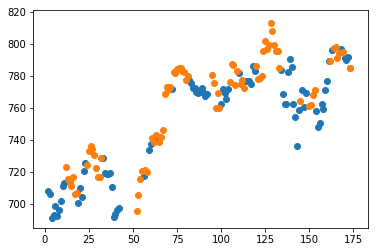

In [19]:
import random
random.seed(1997)

balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(2,len(new_pred) - 1):
    prediction = new_pred[i]
    rand = random.randint(1, 100)
    if (prediction > new_pred[i-1] and balance != 0) or rand <= 5:
        if balance <= 10000:
            money = balance
            balance = 0
        else:
            money = 10000
            balance = balance - 10000
        volume += money / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print("Buy " + str(newy_test[i]))
    elif(volume > 0 and prediction < new_pred[i-1] and prediction * 1.002 < new_pred[i-2]) or rand > 95:
        forSell = volume/4.0
        volume = volume*3.0/4.0
        balance += forSell * newy_test[i]
        selx.append(i)
        sely.append(newy_test[i])
        print("Sell " + str(newy_test[i]))
        print("Balance: " + str(balance))

if(volume != 0):
    balance += volume * newy_test[i]
    volume = 0
    selx.append(i)
    sely.append(newy_test[i])
    print("Sell " + str(newy_test[i]))
    print("Balance: " + str(balance))
    
print("Balance:" + str(balance))
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

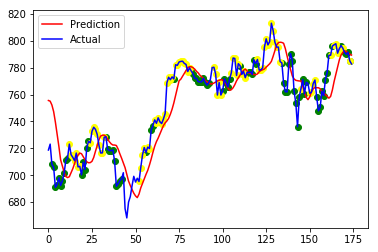

In [21]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()